# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploring The Dataset

In [2]:
ratings = pd.read_csv('/kaggle/input/ml-32m/ml-32m/ratings.csv')
movies = pd.read_csv('/kaggle/input/ml-32m/ml-32m/movies.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")

Number of ratings: 32000204
Number of unique movieId's: 84432
Number of unique users: 200948


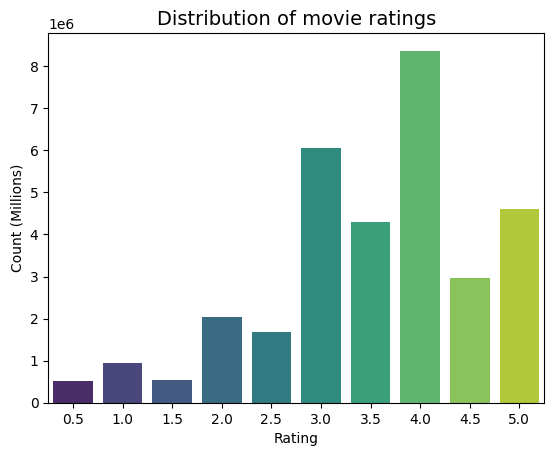

In [6]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.xlabel('Rating')
plt.ylabel('Count (Millions)')
plt.show()

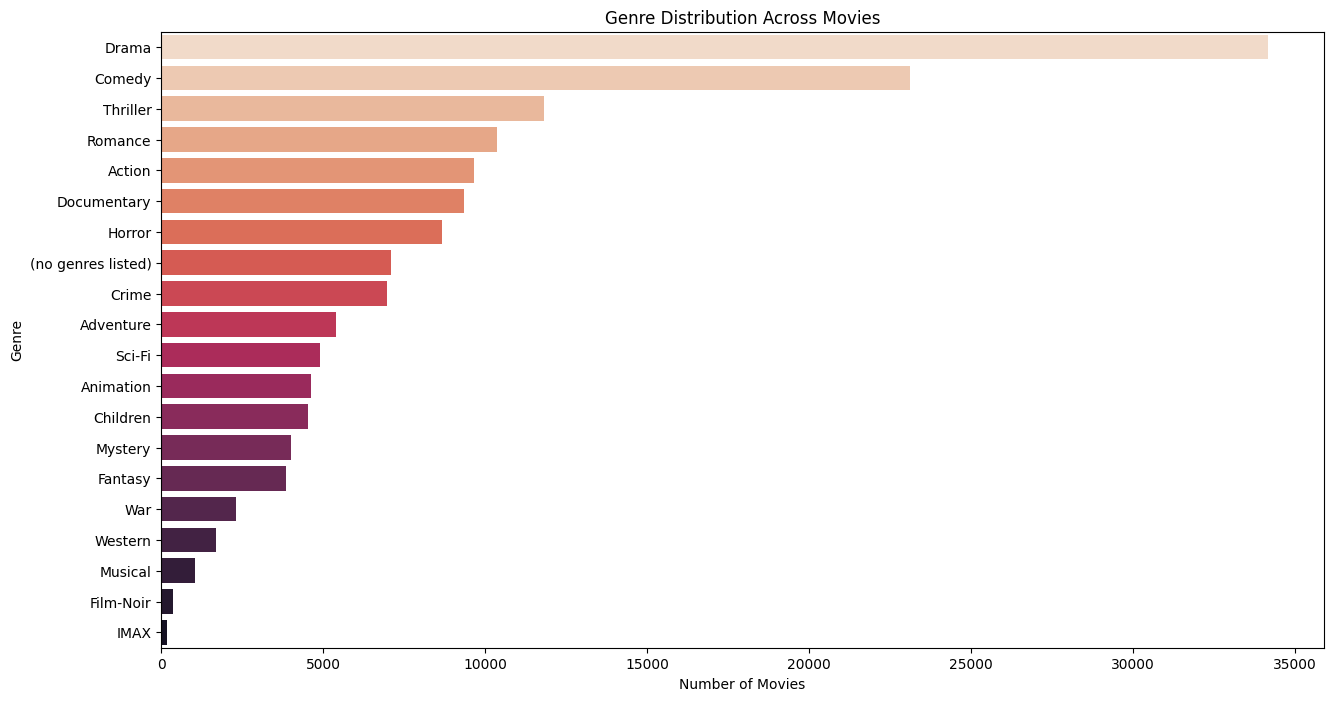

In [10]:
# Genre analysis
movies['genres'] = movies['genres'].str.split('|')
exploded_genres = movies.explode('genres')

plt.figure(figsize=(15, 8))
genre_order = exploded_genres['genres'].value_counts().index
sns.countplot(y='genres', data=exploded_genres, order=genre_order, palette='rocket_r')
plt.title('Genre Distribution Across Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

In [11]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)                             102929
Forrest Gump (1994)                                          100296
Pulp Fiction (1994)                                           98409
Matrix, The (1999)                                            93808
Silence of the Lambs, The (1991)                              90330
Star Wars: Episode IV - A New Hope (1977)                     85010
Fight Club (1999)                                             77332
Jurassic Park (1993)                                          75233
Schindler's List (1993)                                       73849
Lord of the Rings: The Fellowship of the Ring, The (2001)     73122
Name: count, dtype: int64

In [12]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5694,5805,Besotted (2001),[Drama]


In [13]:
print(f"Before filtering: {len(ratings):,} ratings")

# Count ratings per movie and user
movie_counts = ratings.groupby('movieId').size()
user_counts = ratings.groupby('userId').size()

Before filtering: 32,000,204 ratings


# Lowering Sparsity

In [14]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
sparsity = 100 * (1 - n_ratings / (n_users * n_movies))
print(f"Sparsity: {sparsity:.2f}%")

Sparsity: 99.81%


In [15]:
# Filter movies with > 100 ratings
active_movies = movie_counts[movie_counts > 100].index
ratings = ratings[ratings['movieId'].isin(active_movies)]

# Filter users with > 50 ratings
active_users = user_counts[user_counts > 50].index
ratings = ratings[ratings['userId'].isin(active_users)]

print(f"After filtering: {len(ratings):,} ratings")

After filtering: 28,855,006 ratings


In [16]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
sparsity = 100 * (1 - n_ratings / (n_users * n_movies))
print(f"Sparsity: {sparsity:.2f}%")

Sparsity: 98.12%


# Creating Sparse Martix

In [17]:
from scipy.sparse import csr_matrix

def create_X(df):

    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [18]:
X.shape

(126588, 12145)

In [19]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [39]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=11)
similar_movies

[3114, 356, 260, 480, 1270, 364, 588, 1210, 1196, 4306]

# Get Movies

In [40]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_name = input("Enter a movie name: ")

movie_matches = movies[movies['title'].str.contains(movie_name, case=False, na=False)]

if movie_matches.empty:
    print(f"Movie '{movie_name}' not found.")
else:
    movie_id = movie_matches.iloc[0]['movieId']
    movie_title = movie_matches.iloc[0]['title']
    
    similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=11)
    
    print(f"\nRecommended Movies:\n")
    for i in similar_movies:
        print(movie_titles[i])

Enter a movie name:  city hall



Recommended Movies:

Juror, The (1996)
Nixon (1995)
Diabolique (1996)
Mulholland Falls (1996)
Executive Decision (1996)
Up Close and Personal (1996)
Primal Fear (1996)
Time to Kill, A (1996)
Things to Do in Denver When You're Dead (1995)
Courage Under Fire (1996)


#  Dimensionality Reduction with Matrix Factorization (advanced)

In [31]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(12145, 20)

In [41]:
movie_name = input("Enter a movie name: ")

movie_matches = movies[movies['title'].str.contains(movie_name, case=False, na=False)]

if movie_matches.empty:
    print(f"Movie '{movie_name}' not found.")
else:
    movie_id = movie_matches.iloc[0]['movieId']
    movie_title = movie_matches.iloc[0]['title']
    
    similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=11)
    
    print(f"\nRecommended Movies:\n")
    for i in similar_movies:
        print(movie_titles[i])

Enter a movie name:  city hall



Recommended Movies:

Diabolique (1996)
Unforgettable (1996)
Before and After (1996)
Heaven's Prisoners (1996)
Juror, The (1996)
Nixon (1995)
Mulholland Falls (1996)
Last Dance (1996)
Crossing Guard, The (1995)
Carried Away (1996)
